In [1]:
import neo
import os
import numpy as np
import quantities as pq
import matplotlib.pyplot as plt

In [63]:
path = '/home/rgutzen/ProjectsData/wave_analysis_pipeline/LENS/stage04_wavefront_detection/waves.nix'

with neo.NixIO(path) as nio:
    block = nio.read_block()

In [64]:
import sys
sys.path.append('/home/rgutzen/Projects/wavescalephant/pipeline')
from utils import AnalogSignal2ImageSequence

block = AnalogSignal2ImageSequence(block)
signal = block.segments[0].imagesequences[0].as_array()

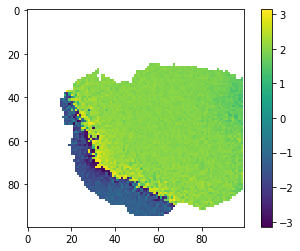

In [65]:
fig, ax = plt.subplots()

vmin = np.nanmin(signal)
vmax = np.nanmax(signal)

img = ax.imshow(signal[0], interpolation='nearest',
          cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(img, ax=ax)

In [6]:
signal.shape

(49603, 9, 5)

In [46]:
frame = signal[0]
bad_sites = (np.array([0,0]), np.array([3,0]))
nan_sites = np.where(np.bitwise_not(np.isfinite(frame)))
rm_idx = np.array([], dtype=int)
for x,y in zip(bad_sites[0], bad_sites[1]):
    inx, iny = np.where(x == nan_sites[0])[0], np.where(y == nan_sites[1])[0]
    rm_ixs = np.append(rm_ids, np.intersect1d(inx, iny, assume_unique=True, return_indices=False))
                      
bad_sites = np.append((np.delete(nan_sites[0], rm_ids), np.delete(nan_sites[1], rm_ids)), bad_sites, axis=1)

(array([0, 0, 0, 0, 1, 1, 2, 2, 3, 4, 5, 7, 8, 8]),
 array([2, 4, 3, 0, 3, 4, 3, 4, 4, 4, 4, 4, 0, 4]))

In [44]:
frame = signal[0]
bad_sites = (np.array([0,0]), np.array([3,0]))
nan_sites = np.where(np.bitwise_not(np.isfinite(frame)))

nrows, ncols = nan_sites.shape
dtype={'names':['f{}'.format(i) for i in range(ncols)],
       'formats':ncols * [bad_sites.dtype]}

C = np.intersect1d(nan_sites.view(dtype), bad_sites.view(dtype))

# This last bit is optional if you're okay with "C" being a structured array...
C = C.view(A.dtype).reshape(-1, ncols)
print(C)

AttributeError: 'tuple' object has no attribute 'shape'

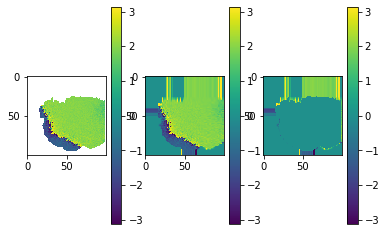

In [70]:
from scipy import interpolate
from copy import copy

frame = signal[0]
x, y = np.where(np.isfinite(frame))
# frame = frame[np.min(x):np.max(x)+1, np.min(y):np.max(y)+1]
# x -= np.min(x)
# y -= np.min(y)            

f = interpolate.interp2d(x, y, frame[x,y], kind='linear')

# znew = f(np.arange(np.max(x)+1), np.arange(np.max(y)+1))
znew = f(np.arange(frame.shape[0]), np.arange(frame.shape[1]))

vmin, vmax = np.nanmin(frame), np.nanmax(frame)

fig, ax = plt.subplots(ncols=3)
img = ax[0].imshow(frame, interpolation='nearest',
                cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(img, ax=ax[0])

img = ax[1].imshow(znew.T, interpolation='nearest',
                cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(img, ax=ax[1])

nan_x, nan_y = np.where(np.bitwise_not(np.isfinite(frame)))
frame = np.zeros_like(frame)
frame[nan_x,nan_y] = znew.T[nan_x,nan_y]

# for xi, yi in zip(x, y):
#     frame[xi,yi] = znew.T[xi,yi]
img = ax[2].imshow(frame, interpolation='nearest',
                cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(img, ax=ax[2])

In [77]:
print(np.min(x), np.max(x))
print(np.min(y), np.max(y))

25 94
15 98


(83, 69)


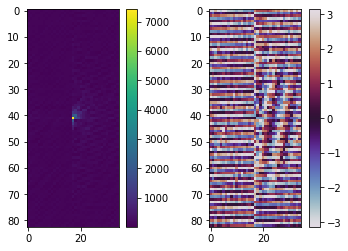

In [86]:
from scipy.fftpack import fft2, ifft2
from numpy.fft import fftshift, rfftn

print(znew.shape)
Fsignal = fftshift(rfftn(znew, axes=(0,1)))

fig, ax = plt.subplots(ncols=2)

img = ax[0].imshow(np.abs(Fsignal), interpolation='nearest',
          cmap='viridis')
plt.colorbar(img, ax=ax[0])
img = ax[1].imshow(np.angle(Fsignal), interpolation='nearest',
          cmap='twilight')
plt.colorbar(img, ax=ax[1])